Dataset: https://www.kaggle.com/c/bike-sharing-demand/overview

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [21]:
df = pd.read_csv('../datasets/bike-sharing-demand/train.csv')

# EDA: Time Series Analysis

In [22]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [25]:
def decompose_bike_sharing_demand(df, share_type='count', samples=250, period=24):
    if samples == 'all':
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

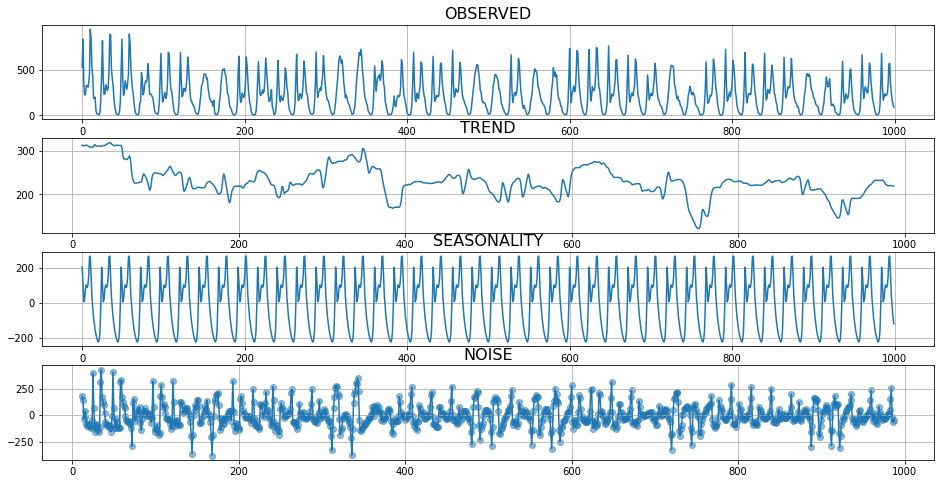

In [26]:
decompose_bike_sharing_demand(df, samples=1000, period=24)

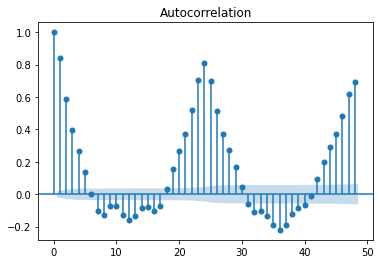

In [27]:
plot_acf(df['count'].values, lags=48)
plt.show()

# Time Series Modelling

# Microsoft's Light Gradient Boosting Machine

In [28]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [29]:
#convert datetime from object to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
#set datetime as index
df = df.set_index(df.datetime)
#drop datetime column
df.drop('datetime', axis=1, inplace=True)

#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
#drop casual and registered columns
df.drop(['casual', 'registered'], axis=1, inplace=True)

In [30]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


In [31]:
def train_time_series_with_folds(df, horizon=24*7):
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

# Train Model without Lags

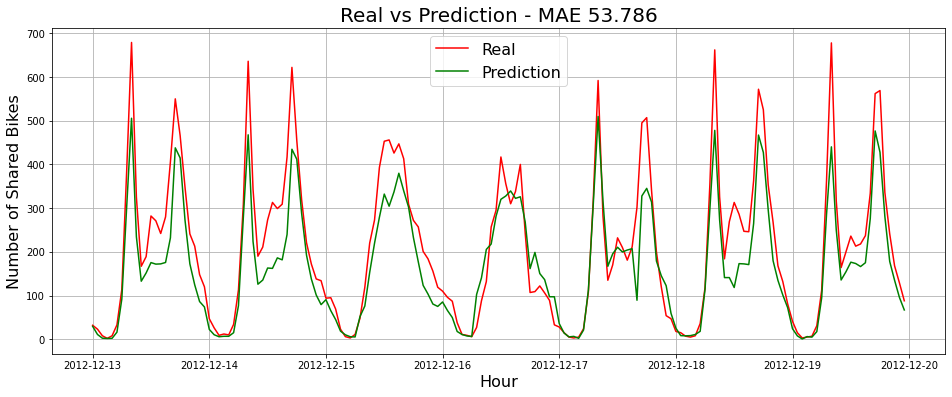

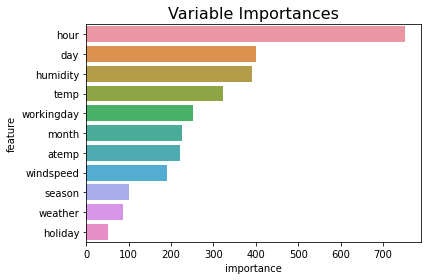

In [32]:
train_time_series_with_folds(df)

# Train Model with Lags

In [33]:
#create 1 week lag variable by shifting the target value for 1 week
df['count_prev_week_same_hour'] = df['count'].shift(24*7)
#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

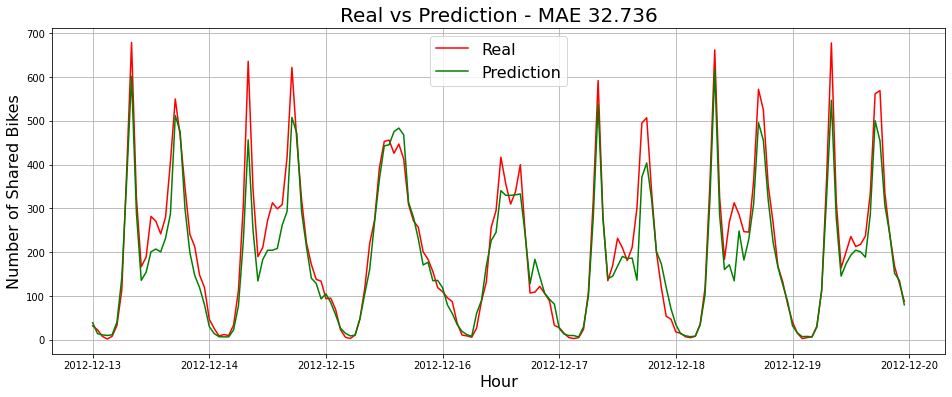

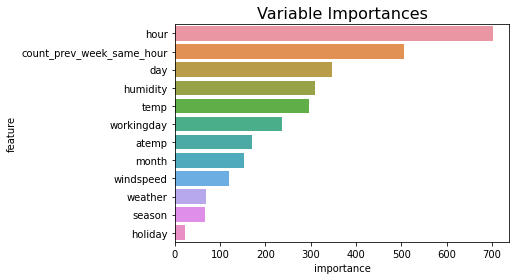

In [34]:
train_time_series_with_folds(df)

# Train Model with Lags + Autorregressive + Prophet Features

In [43]:
from prophet import Prophet

In [44]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-08 07:00:00,1,0,0,2,6.56,9.090,74,7.0015,9,7,8,1
2011-01-08 08:00:00,1,0,0,3,6.56,9.090,93,7.0015,15,8,8,1
2011-01-08 09:00:00,1,0,0,3,6.56,9.090,93,7.0015,20,9,8,1
2011-01-08 10:00:00,1,0,0,2,7.38,9.850,80,11.0014,61,10,8,1
2011-01-08 11:00:00,1,0,0,2,8.20,9.090,69,26.0027,62,11,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


In [45]:
def prophet_features(df, horizon=24*7):
    temp_df = df.reset_index()
    temp_df = temp_df[['datetime', 'count']]
    temp_df.rename(columns={'datetime': 'ds', 'count': 'y'}, inplace=True)
    
    #take last week of the dataset for validation
    train, test = temp_df.iloc[:-horizon,:], temp_df.iloc[-horizon:,:]

    m = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False
            )

    m.fit(train)
    predictions_train = m.predict(train.drop('y', axis=1))
    predictions_test = m.predict(test.drop('y', axis=1))
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions

In [46]:
prophet_features(df)

Initial log joint probability = -297.793
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17463.4     0.0517208        828.93           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       17477.2    0.00013427       131.382   1.932e-06       0.001      258  LS failed, Hessian reset 
     199       17477.7   0.000502373       89.3899           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       17479.2   7.55242e-05       83.5983   4.731e-07       0.001      372  LS failed, Hessian reset 
     299       17480.2   0.000354156       61.7042           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       17480.5   0.000813512        369.91   1.118e-05       0.001      524  LS failed, Hessian rese

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-08 07:00:00,27.952485,-148.710763,273.394070,27.952485,27.952485,34.884305,34.884305,34.884305,25.144263,25.144263,25.144263,9.740041,9.740041,9.740041,0.0,0.0,0.0,62.836790
1,2011-01-08 08:00:00,27.997496,-108.380199,313.100229,27.997496,27.997496,75.693088,75.693088,75.693088,65.917792,65.917792,65.917792,9.775296,9.775296,9.775296,0.0,0.0,0.0,103.690584
2,2011-01-08 09:00:00,28.042507,-110.529596,310.746024,28.042507,28.042507,73.389120,73.389120,73.389120,63.622270,63.622270,63.622270,9.766849,9.766849,9.766849,0.0,0.0,0.0,101.431627
3,2011-01-08 10:00:00,28.087518,-123.376964,295.713173,28.087518,28.087518,52.425360,52.425360,52.425360,42.714543,42.714543,42.714543,9.710817,9.710817,9.710817,0.0,0.0,0.0,80.512878
4,2011-01-08 11:00:00,28.132529,-151.419979,292.557467,28.132529,28.132529,37.206159,37.206159,37.206159,27.602455,27.602455,27.602455,9.603704,9.603704,9.603704,0.0,0.0,0.0,65.338687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2012-12-19 19:00:00,229.227044,175.590781,629.692335,228.324520,230.422915,167.454822,167.454822,167.454822,169.787621,169.787621,169.787621,-2.332800,-2.332800,-2.332800,0.0,0.0,0.0,396.681866
164,2012-12-19 20:00:00,229.208279,89.282552,504.498197,228.296946,230.417148,70.548716,70.548716,70.548716,72.384932,72.384932,72.384932,-1.836216,-1.836216,-1.836216,0.0,0.0,0.0,299.756995
165,2012-12-19 21:00:00,229.189513,-18.687897,406.192186,228.269524,230.409267,-30.297193,-30.297193,-30.297193,-28.979129,-28.979129,-28.979129,-1.318064,-1.318064,-1.318064,0.0,0.0,0.0,198.892319
166,2012-12-19 22:00:00,229.170747,-93.020177,343.681369,228.242102,230.402479,-93.848431,-93.848431,-93.848431,-93.065211,-93.065211,-93.065211,-0.783220,-0.783220,-0.783220,0.0,0.0,0.0,135.322315


In [49]:
def train_time_series_with_folds_autoreg_prophet_features(df, horizon=24*7, lags=[1, 2, 3, 4, 5]):
    new_prophet_features = prophet_features(df, horizon=horizon)
    df.reset_index(inplace=True)
    
    df = pd.merge(df, new_prophet_features, left_on=['datetime'], right_on=['ds'], how='inner')
    df.drop('ds', axis=1, inplace=True)
    df.set_index('datetime', inplace=True)
    
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any')
    
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

Initial log joint probability = -297.793
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17463.4     0.0517208        828.93           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       17477.2    0.00013427       131.382   1.932e-06       0.001      258  LS failed, Hessian reset 
     199       17477.7   0.000502373       89.3899           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       17479.2   7.55242e-05       83.5983   4.731e-07       0.001      372  LS failed, Hessian reset 
     299       17480.2   0.000354156       61.7042           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       17480.5   0.000813512        369.91   1.118e-05       0.001      524  LS failed, Hessian rese

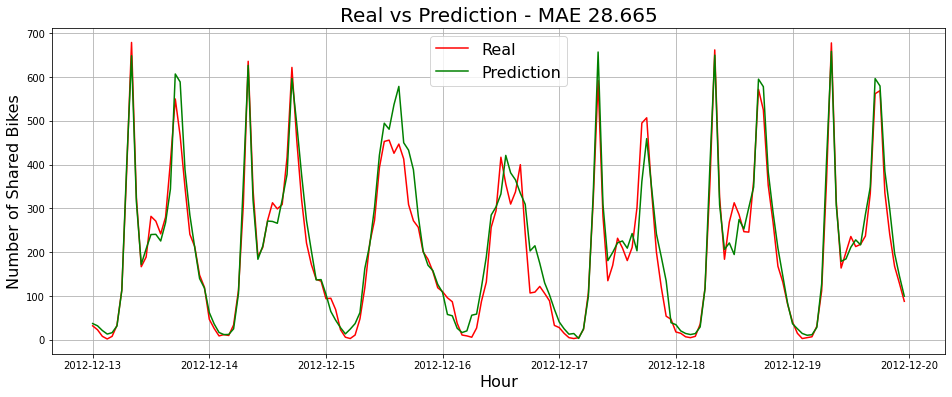

In [50]:
import warnings
warnings.simplefilter('ignore')

train_time_series_with_folds_autoreg_prophet_features(df)